## Holder analysis

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
df_contracts_bad = pd.read_csv('../csv_outputs/bad_tokens/master_contract.csv')
df_contracts_good = pd.read_csv('../csv_outputs/good_tokens/master_contract.csv')

df_holders_list_bad = pd.read_csv('../csv_outputs/bad_tokens/master_holders_list.csv')
df_holders_list_good = pd.read_csv('../csv_outputs/good_tokens/master_holders_list.csv')

df_holders_bad = pd.read_csv('../csv_outputs/bad_tokens/master_holders.csv')
df_holders_good = pd.read_csv('../csv_outputs/good_tokens/master_holders.csv')



C:\Users\Famiglia\AppData\Local\Temp\ipykernel_16224\3873646800.py:5: DtypeWarning: Columns (4,5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_holders_list_good = pd.read_csv('../csv_outputs/good_tokens/master_holders_list.csv')


## Distribution of number of total holders

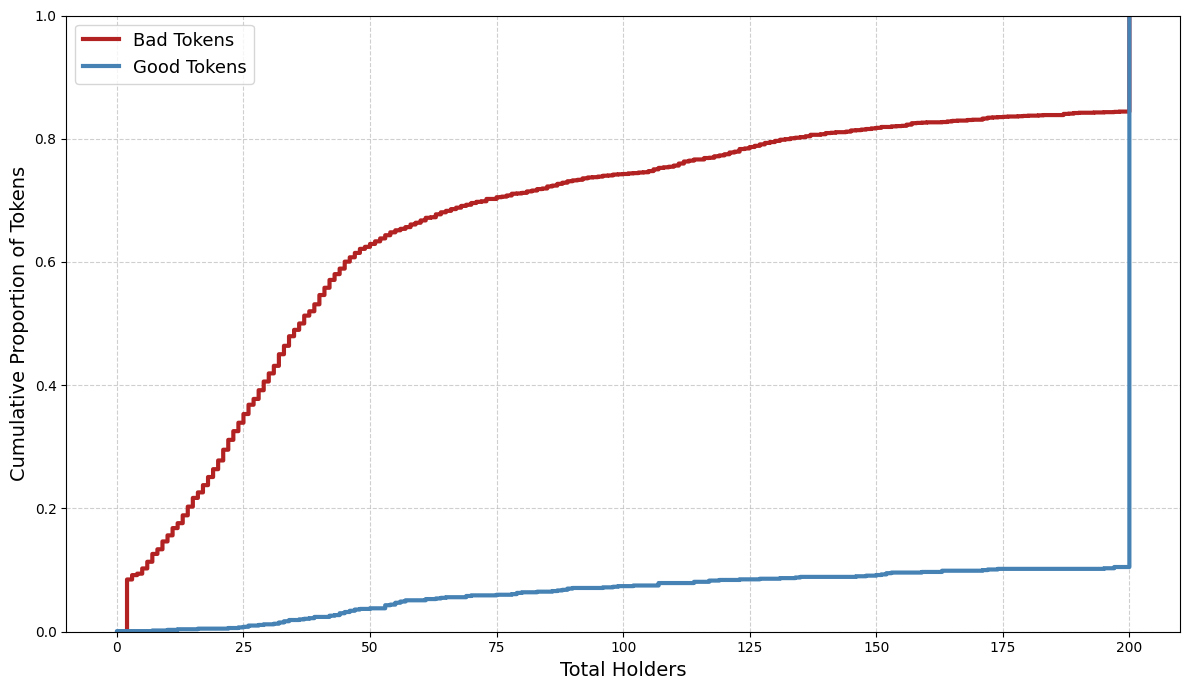

In [8]:
# Ensure numeric
df_holders_bad['total_holders'] = pd.to_numeric(df_holders_bad['total_holders'], errors='coerce')
df_holders_good['total_holders'] = pd.to_numeric(df_holders_good['total_holders'], errors='coerce')

# Drop NaNs
bad_holders = df_holders_bad['total_holders'].dropna()
good_holders = df_holders_good['total_holders'].dropna()

# Create single figure with bigger size
plt.figure(figsize=(12, 7))

# Plot both CDFs with thicker lines and increased linewidth
sns.ecdfplot(bad_holders, label='Bad Tokens', color='firebrick', linewidth=3)
sns.ecdfplot(good_holders, label='Good Tokens', color='steelblue', linewidth=3)

# Labels with bigger font size
plt.xlabel('Total Holders', fontsize=14)
plt.ylabel('Cumulative Proportion of Tokens', fontsize=14)

# Legend with bigger font size
plt.legend(fontsize=13)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("holdercount.pdf",format="pdf")
plt.show()


## Owner wallet contains \< 5% of the circulating token supply

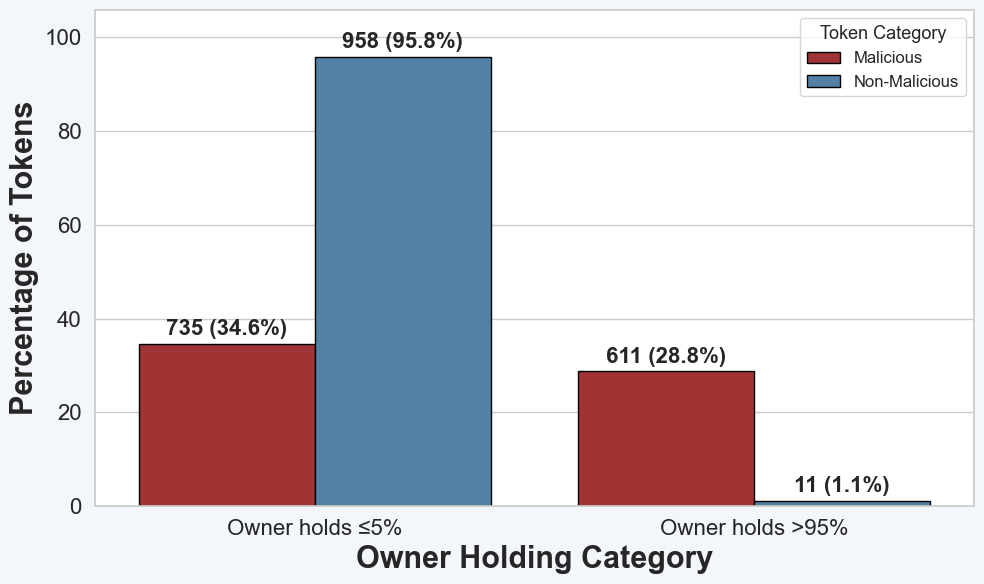

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Your existing code for ≤5% ownership ---
def compute_owner_percent(df_contracts, df_holders_list, df_holders):
    df_merged = df_holders_list.merge(df_contracts[['token_address', 'owner']], on='token_address', how='left')
    df_merged = df_merged.merge(df_holders[['token_address', 'total_circulating_supply']], on='token_address', how='left')

    # Normalize casing
    df_merged['holder_address'] = df_merged['holder_address'].str.lower()
    df_merged['owner'] = df_merged['owner'].str.lower()

    # Keep only rows where owner is the holder
    df_owner = df_merged[df_merged['holder_address'] == df_merged['owner']].copy()

    # Ensure numeric and drop invalid rows
    df_owner['balance'] = pd.to_numeric(df_owner['balance'], errors='coerce')
    df_owner['total_circulating_supply'] = pd.to_numeric(df_owner['total_circulating_supply'], errors='coerce')
    df_owner = df_owner.dropna(subset=['balance', 'total_circulating_supply'])
    df_owner = df_owner[df_owner['total_circulating_supply'] > 0]

    # Compute % ownership
    df_owner['owner_percent'] = (df_owner['balance'] / df_owner['total_circulating_supply']) * 100

    tokens_over_5 = df_owner[df_owner['owner_percent'] > 5]['token_address'].nunique()
    total_tokens = df_contracts['token_address'].nunique()
    tokens_5_or_less = total_tokens - tokens_over_5

    return {
        '>5% Owner': tokens_over_5,
        '≤5% Owner': tokens_5_or_less,
        'Total': total_tokens,
        'df_owner': df_owner  # Keep this for reuse
    }

# --- Compute for good and bad tokens (≤5%) ---
bad_stats = compute_owner_percent(df_contracts_bad, df_holders_list_bad, df_holders_bad)
good_stats = compute_owner_percent(df_contracts_good, df_holders_list_good, df_holders_good)

# --- Now compute the >95% ownership stats using the same merged DataFrame ---
def compute_over_95(df_contracts, df_owner):
    tokens_over_95 = df_owner[df_owner['owner_percent'] > 95]['token_address'].nunique()
    total_tokens = df_contracts['token_address'].nunique()
    tokens_95_or_less = total_tokens - tokens_over_95
    return {
        '>95% Owner': tokens_over_95,
        '≤95% Owner': tokens_95_or_less,
        'Total': total_tokens
    }

bad_95_stats = compute_over_95(df_contracts_bad, bad_stats['df_owner'])
good_95_stats = compute_over_95(df_contracts_good, good_stats['df_owner'])

# --- Prepare combined DataFrame for plotting ---
combined_plot_df = pd.DataFrame({
    'Owner Category': ['Owner holds ≤5%', 'Owner holds >95%'] * 2,
    'Token Type': ['Bad'] * 2 + ['Good'] * 2,
    'Token Count': [
        bad_stats['≤5% Owner'], bad_95_stats['>95% Owner'],
        good_stats['≤5% Owner'], good_95_stats['>95% Owner']
    ],
    'Total Tokens': [bad_stats['Total']] * 2 + [good_stats['Total']] * 2
})

# Calculate percentages
combined_plot_df['Percentage'] = (
    combined_plot_df['Token Count'] / combined_plot_df['Total Tokens']
) * 100

# --- Plotting ---
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

ax = sns.barplot(
    data=combined_plot_df,
    x='Owner Category',
    y='Percentage',
    hue='Token Type',
    palette={'Bad': 'firebrick', 'Good': 'steelblue'},
    edgecolor='black',
    linewidth=1
)

# Annotate bars
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2

    if i < len(combined_plot_df):
        row = combined_plot_df.iloc[i]
        count = row['Token Count']
        percent = row['Percentage']
        ax.text(x, height + 1, f'{count} ({percent:.1f}%)',
                ha='center', va='bottom', fontsize=16, fontweight='bold')

# Axis styling
ax.set_xlabel("Owner Holding Category", fontsize=22, fontweight='bold')
ax.set_ylabel("Percentage of Tokens", fontsize=22, fontweight='bold')
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylim(0, max(combined_plot_df['Percentage'].max() + 10, 100))
plt.gcf().set_facecolor('#f3f6fa')

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Malicious', 'Non-Malicious'], title='Token Category',
          title_fontsize=13, fontsize=12)

#plt.title("Owner Distribution: ≤5% vs >95% of Circulating Supply", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("owner_token_distribution_5_95.pdf")
plt.show()


## Creator wallet contains \< 5% of the circulating token supply

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_11804\1954584874.py:8: DtypeWarning: Columns (4,5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_holders_list_good = pd.read_csv('../csv_outputs/good_tokens/master_holders_list.csv')
C:\Users\Famiglia\AppData\Local\Temp\ipykernel_11804\1954584874.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=plot_df_bad, x='Creator Category', y='Token Count',


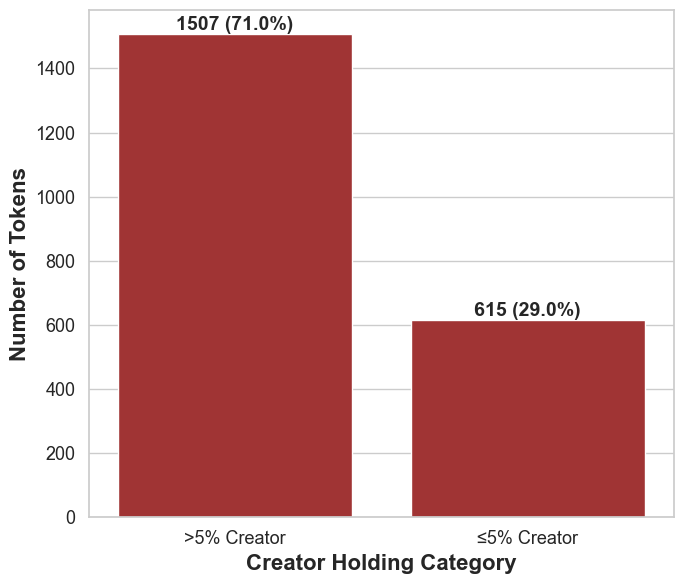

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_11804\1954584874.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=plot_df_good, x='Creator Category', y='Token Count',


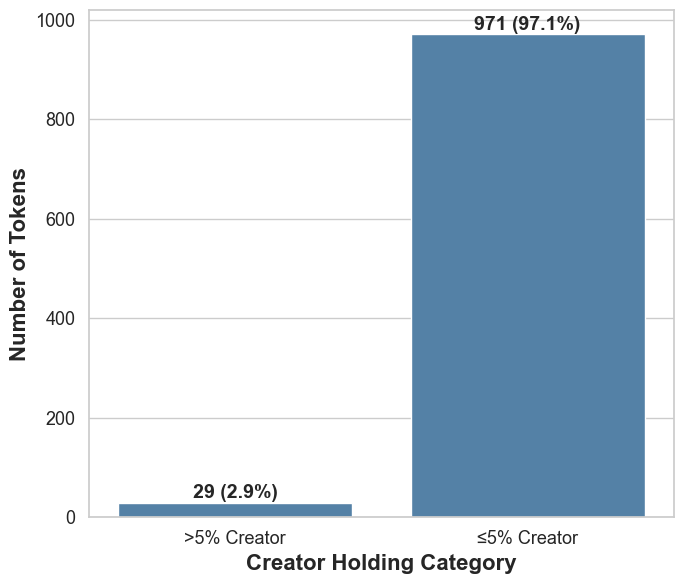

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_11804\1954584874.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df_bad, x='Creator Category', y='Token Count',
C:\Users\Famiglia\AppData\Local\Temp\ipykernel_11804\1954584874.py:147: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df_good, x='Creator Category', y='Token Count',


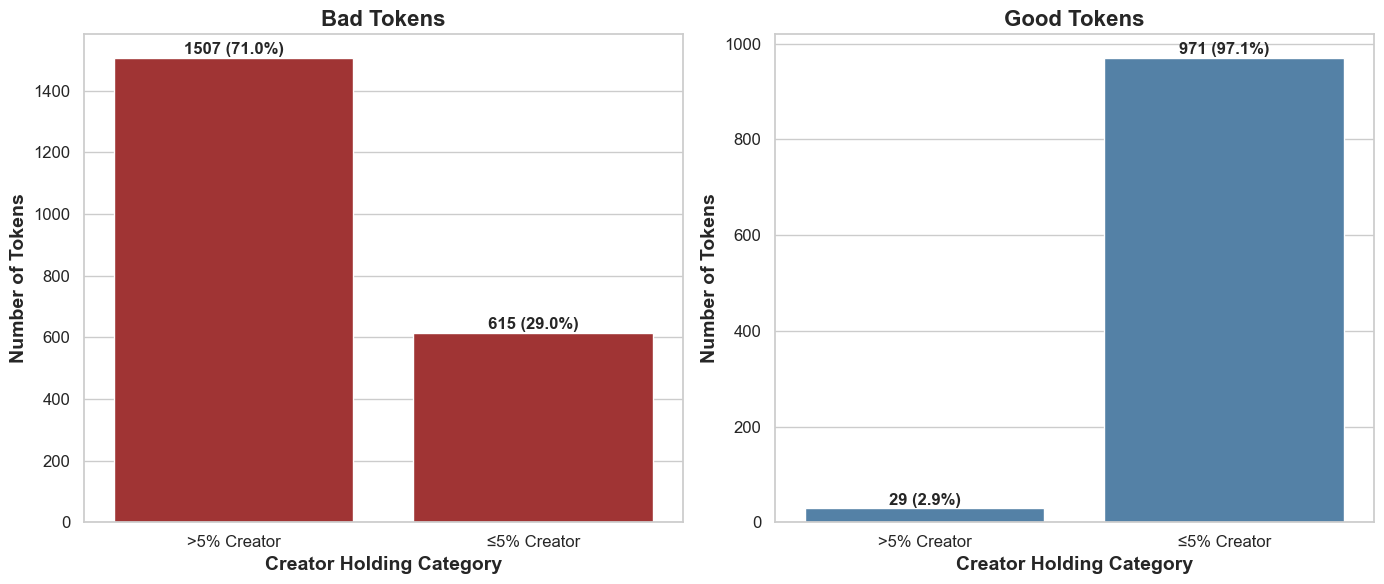

In [ ]:
# Owner/creator wallet contains < 5% of circulating token supply

# Load datasets
df_contracts_bad = pd.read_csv('../csv_outputs/bad_tokens/master_contract.csv')
df_contracts_good = pd.read_csv('../csv_outputs/good_tokens/master_contract.csv')

df_holders_list_bad = pd.read_csv('../csv_outputs/bad_tokens/master_holders_list.csv')
df_holders_list_good = pd.read_csv('../csv_outputs/good_tokens/master_holders_list.csv')

df_holders_bad = pd.read_csv('../csv_outputs/bad_tokens/master_holders.csv')
df_holders_good = pd.read_csv('../csv_outputs/good_tokens/master_holders.csv')

# Helper function to compute tokens over/under 5% for a given category
def compute_owner_percent(df_contracts, df_holders_list, df_holders):
    df_merged = df_holders_list.merge(df_contracts[['token_address', 'creator']], on='token_address', how='left')
    df_merged = df_merged.merge(df_holders[['token_address', 'total_circulating_supply']], on='token_address', how='left')

    # Normalize address casing
    df_merged['holder_address'] = df_merged['holder_address'].str.lower()
    df_merged['creator'] = df_merged['creator'].str.lower()

    # Filter to rows where holder is the owner
    df_owner = df_merged[df_merged['holder_address'] == df_merged['creator']].copy()

    # Clean and convert numeric fields
    df_owner['balance'] = pd.to_numeric(df_owner['balance'], errors='coerce')
    df_owner['total_circulating_supply'] = pd.to_numeric(df_owner['total_circulating_supply'], errors='coerce')
    df_owner = df_owner.dropna(subset=['balance', 'total_circulating_supply'])
    df_owner = df_owner[df_owner['total_circulating_supply'] > 0]

    # Compute owner percentage
    df_owner['creator_percent'] = (df_owner['balance'] / df_owner['total_circulating_supply']) * 100

    # Count tokens where owner holds >5%
    tokens_over_5 = df_owner[df_owner['creator_percent'] > 5]['token_address'].nunique()
    total_tokens = df_contracts['token_address'].nunique()
    tokens_5_or_less = total_tokens - tokens_over_5

    return {
        '>5% Creator': tokens_over_5,
        '≤5% Creator': tokens_5_or_less,
        'Total': total_tokens
    }

# Compute for both categories
bad_stats = compute_owner_percent(df_contracts_bad, df_holders_list_bad, df_holders_bad)
good_stats = compute_owner_percent(df_contracts_good, df_holders_list_good, df_holders_good)

# Prepare data for plotting
plot_df_bad = pd.DataFrame({
    'Creator Category': ['>5% Creator', '≤5% Creator'],
    'Token Count': [bad_stats['>5% Creator'], bad_stats['≤5% Creator']]
})
plot_df_bad['Percentage'] = (plot_df_bad['Token Count'] / bad_stats['Total']) * 100

plot_df_good = pd.DataFrame({
    'Creator Category': ['>5% Creator', '≤5% Creator'],
    'Token Count': [good_stats['>5% Creator'], good_stats['≤5% Creator']]
})
plot_df_good['Percentage'] = (plot_df_good['Token Count'] / good_stats['Total']) * 100

import matplotlib.pyplot as plt
import seaborn as sns

# --- Plot for Bad Tokens (Creator) ---
plt.figure(figsize=(7, 6))
sns.set(style="whitegrid")
ax1 = sns.barplot(data=plot_df_bad, x='Creator Category', y='Token Count',
                  palette=['firebrick', 'firebrick'])

# Add text annotations
for i, row in plot_df_bad.iterrows():
    count = row['Token Count']
    percent = row['Percentage']
    ax1.text(i, count + 1, f'{count} ({percent:.1f}%)',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

# Set axis labels with larger bold fonts
ax1.set_xlabel("Creator Holding Category", fontsize=16, fontweight='bold')
ax1.set_ylabel("Number of Tokens", fontsize=16, fontweight='bold')

# Increase tick font sizes
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)

# Remove title
# ax1.set_title(...) is intentionally omitted

plt.tight_layout()
plt.show()


# --- Plot for Good Tokens (Creator) ---
plt.figure(figsize=(7, 6))
ax2 = sns.barplot(data=plot_df_good, x='Creator Category', y='Token Count',
                  palette=['steelblue', 'steelblue'])

# Add text annotations
for i, row in plot_df_good.iterrows():
    count = row['Token Count']
    percent = row['Percentage']
    ax2.text(i, count + 1, f'{count} ({percent:.1f}%)',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

# Set axis labels with larger bold fonts
ax2.set_xlabel("Creator Holding Category", fontsize=16, fontweight='bold')
ax2.set_ylabel("Number of Tokens", fontsize=16, fontweight='bold')

# Increase tick font sizes
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)

# Remove title
# ax2.set_title(...) is intentionally omitted

plt.tight_layout()
plt.show()




C:\Users\Famiglia\AppData\Local\Temp\ipykernel_11804\2248611024.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Creator holds >5% of supply', 'Creator holds ≤5% of supply'])


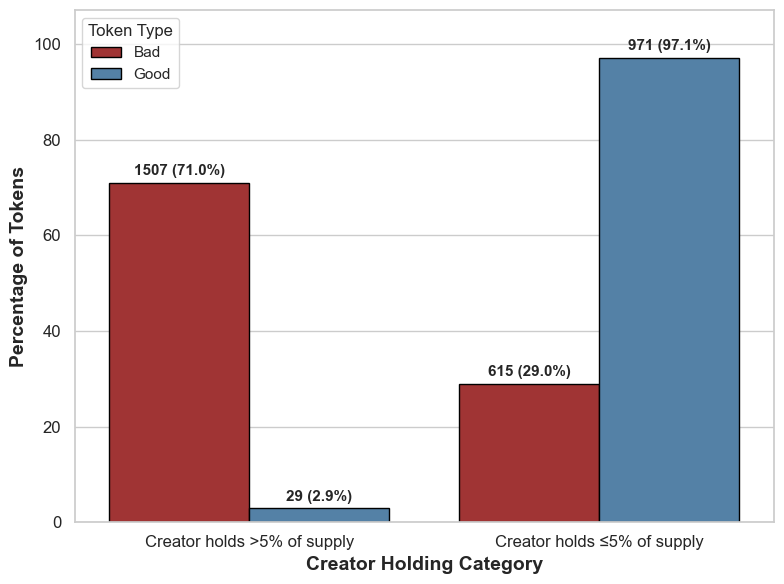

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine and normalize the data for percentages
combined_df = pd.DataFrame({
    'Creator Category': ['>5% Creator', '≤5% Creator'] * 2,
    'Percentage': [
        (bad_stats['>5% Creator'] / bad_stats['Total']) * 100,
        (bad_stats['≤5% Creator'] / bad_stats['Total']) * 100,
        (good_stats['>5% Creator'] / good_stats['Total']) * 100,
        (good_stats['≤5% Creator'] / good_stats['Total']) * 100
    ],
    'Token Count': [
        bad_stats['>5% Creator'], bad_stats['≤5% Creator'],
        good_stats['>5% Creator'], good_stats['≤5% Creator']
    ],
    'Token Type': ['Bad'] * 2 + ['Good'] * 2
})

# --- Plotting ---
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Plot percentages instead of raw counts
ax = sns.barplot(
    data=combined_df,
    x='Creator Category',
    y='Percentage',
    hue='Token Type',
    palette={'Bad': 'firebrick', 'Good': 'steelblue'},
    edgecolor='black',       # Outline color
    linewidth=1            # Outline thickness
)

# Add annotations: count and percentage
for i, row in combined_df.iterrows():
    category = row['Creator Category']
    token_type = row['Token Type']
    percent = row['Percentage']
    count = row['Token Count']

    # Calculate bar position offset
    xpos = list(combined_df['Creator Category'].unique()).index(category)
    offset = -0.2 if token_type == 'Bad' else 0.2
    ax.text(xpos + offset, percent + 1, f'{count} ({percent:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Axis labels and formatting
ax.set_xlabel("Creator Holding Category", fontsize=14, fontweight='bold')
ax.set_ylabel("Percentage of Tokens", fontsize=14, fontweight='bold')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylim(0, max(combined_df['Percentage']) + 10)  # add space for labels

# Legend
ax.legend(title='Token Type', title_fontsize=12, fontsize=11)

ax.set_xticklabels(['Creator holds >5% of supply', 'Creator holds ≤5% of supply'])
plt.savefig("creator_token_distribution.pdf")
plt.tight_layout()
plt.show()


## Non owner/creator wallets holding > 5% of circulating supply

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_11804\71653924.py:9: DtypeWarning: Columns (4,5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_holders_list_good = pd.read_csv('../csv_outputs/good_tokens/master_holders_list.csv')
C:\Users\Famiglia\AppData\Local\Temp\ipykernel_11804\71653924.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_holders_list_good['is_owner'] = df_holders_list_good['is_owner'].fillna(False).astype(bool)
C:\Users\Famiglia\AppData\Local\Temp\ipykernel_11804\71653924.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_si

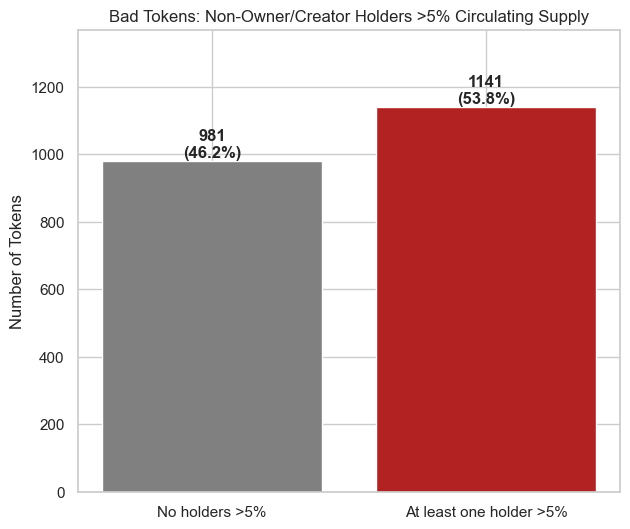

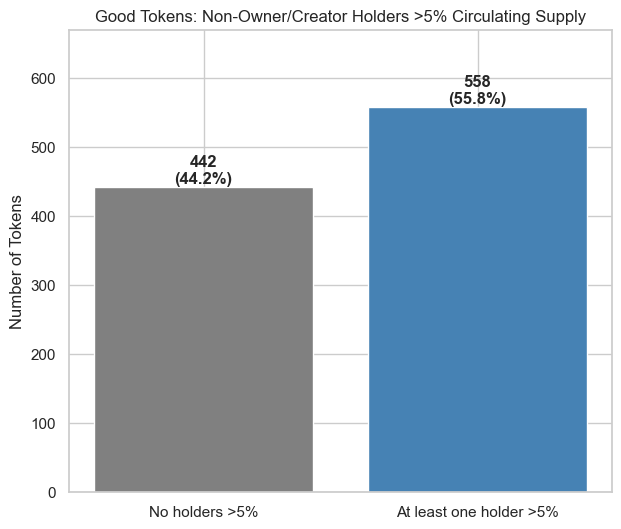

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_holders_bad = pd.read_csv('../csv_outputs/bad_tokens/master_holders.csv') 
df_holders_good = pd.read_csv('../csv_outputs/good_tokens/master_holders.csv')

df_holders_list_bad = pd.read_csv('../csv_outputs/bad_tokens/master_holders_list.csv') 
df_holders_list_good = pd.read_csv('../csv_outputs/good_tokens/master_holders_list.csv')

df_holders_list_good['is_owner'] = df_holders_list_good['is_owner'].fillna(False).astype(bool)
df_holders_list_good['is_creator'] = df_holders_list_good['is_creator'].fillna(False).astype(bool)

df_holders_list_bad['is_owner'] = df_holders_list_bad['is_owner'].fillna(False).astype(bool)
df_holders_list_bad['is_creator'] = df_holders_list_bad['is_creator'].fillna(False).astype(bool)


# --- Function to compute stats ---
def compute_token_exceeding_stats(df_holders_summary, df_holders_list):
    total_tokens = df_holders_summary['token_address'].nunique()

    # Exclude owner and creator addresses
    df_non_owner_creator = df_holders_list[
        (~df_holders_list['is_owner']) & (~df_holders_list['is_creator'])
    ]

    # Group by token and check if any non-core holder exceeds 5%
    token_has_exceeding_holder = (
        df_non_owner_creator
        .groupby('token_address')['exceeds_5_percent']
        .any()
    )

    tokens_with_exceeding = token_has_exceeding_holder.sum()
    tokens_without_exceeding = total_tokens - tokens_with_exceeding

    return tokens_without_exceeding, tokens_with_exceeding, total_tokens

# Compute stats for bad tokens
bad_no_exceed, bad_yes_exceed, total_bad = compute_token_exceeding_stats(df_holders_bad, df_holders_list_bad)
bad_counts = [bad_no_exceed, bad_yes_exceed]
bad_percentages = [count / total_bad * 100 for count in bad_counts]

# Plot for bad tokens
labels = ['No holders >5%', 'At least one holder >5%']
plt.figure(figsize=(7, 6))
bars = plt.bar(labels, bad_counts, color=['grey', 'firebrick'])

for bar, count, perc in zip(bars, bad_counts, bad_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f'{count}\n({perc:.1f}%)',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.title('Bad Tokens: Non-Owner/Creator Holders >5% Circulating Supply')
plt.ylabel('Number of Tokens')
plt.ylim(0, max(bad_counts) * 1.2)
plt.show()


# Compute stats for good tokens
good_no_exceed, good_yes_exceed, total_good = compute_token_exceeding_stats(df_holders_good, df_holders_list_good)
good_counts = [good_no_exceed, good_yes_exceed]
good_percentages = [count / total_good * 100 for count in good_counts]

# Plot for good tokens
plt.figure(figsize=(7, 6))
bars = plt.bar(labels, good_counts, color=['grey', 'steelblue'])

for bar, count, perc in zip(bars, good_counts, good_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f'{count}\n({perc:.1f}%)',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.title('Good Tokens: Non-Owner/Creator Holders >5% Circulating Supply')
plt.ylabel('Number of Tokens')
plt.ylim(0, max(good_counts) * 1.2)
plt.show()


In [20]:
df_holders_bad = pd.read_csv('../csv_outputs/bad_tokens/master_holders.csv') 
df_holders_good = pd.read_csv('../csv_outputs/good_tokens/master_holders.csv')

df_holders_list_bad = pd.read_csv('../csv_outputs/bad_tokens/master_holders_list.csv') 
df_holders_list_good = pd.read_csv('../csv_outputs/good_tokens/master_holders_list.csv')

df_holders_list_bad.columns

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_11804\1128320645.py:5: DtypeWarning: Columns (4,5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_holders_list_good = pd.read_csv('../csv_outputs/good_tokens/master_holders_list.csv')


Index(['token_address', 'chain', 'token_name', 'holder_address', 'is_owner',
       'is_creator', 'balance', 'percentage_of_total_supply',
       'percentage_of_circulating_supply', 'exceeds_5_percent'],
      dtype='object')

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_11804\4027442413.py:7: DtypeWarning: Columns (4,5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_good = pd.read_csv('../csv_outputs/good_tokens/master_holders_list.csv')
C:\Users\Famiglia\AppData\Local\Temp\ipykernel_11804\4027442413.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_owner'] = df['is_owner'].fillna(False).astype(bool)
C:\Users\Famiglia\AppData\Local\Temp\ipykernel_11804\4027442413.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_creator'

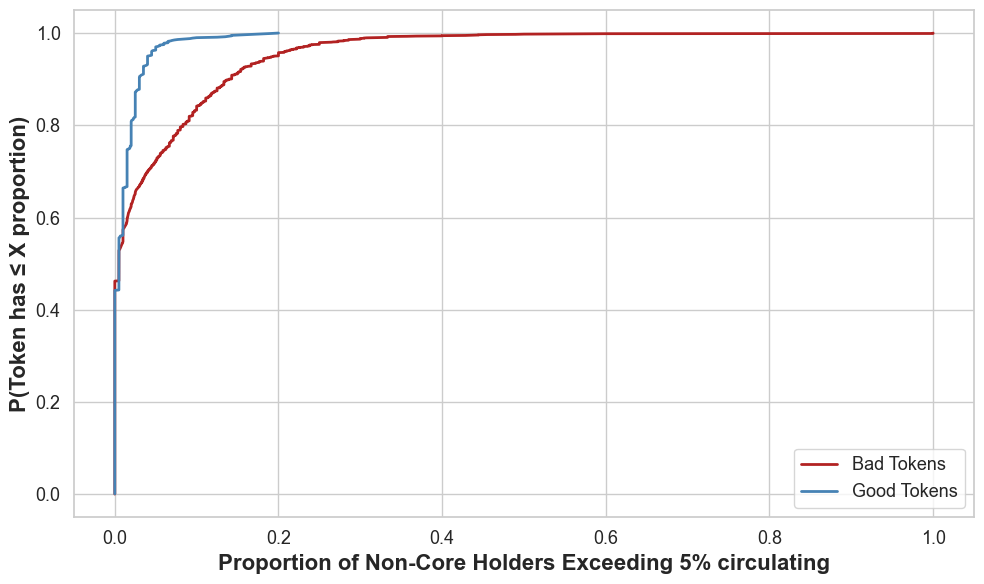

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df_bad = pd.read_csv('../csv_outputs/bad_tokens/master_holders_list.csv')
df_good = pd.read_csv('../csv_outputs/good_tokens/master_holders_list.csv')

# Preprocess
for df in [df_bad, df_good]:
    df['is_owner'] = df['is_owner'].fillna(False).astype(bool)
    df['is_creator'] = df['is_creator'].fillna(False).astype(bool)
    df['exceeds_5_percent'] = df['exceeds_5_percent'].fillna(False).astype(bool)

# Compute proportions of >5% non-core holders per token
def compute_proportions(df):
    all_holders = df.groupby('token_address')['holder_address'].count()
    exceeding_non_core = df[~df['is_owner'] & ~df['is_creator'] & df['exceeds_5_percent']]
    exceeding_counts = exceeding_non_core.groupby('token_address')['holder_address'].count()
    proportion = (exceeding_counts / all_holders).fillna(0)
    return proportion

prop_bad = compute_proportions(df_bad)
prop_good = compute_proportions(df_good)

# Plot CDF
plt.figure(figsize=(10, 6))

for data, label, color in [
    (prop_bad, "Bad Tokens", "firebrick"),
    (prop_good, "Good Tokens", "steelblue")
]:
    sorted_vals = np.sort(data)
    cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
    plt.plot(sorted_vals, cdf, label=label, linewidth=2, color=color)

# Remove title
# plt.title("CDF of Proportion of >5% Holders (Non-Core Addresses)")

# Set bold, larger axis labels
plt.xlabel("Proportion of Non-Core Holders Exceeding 5% circulating", fontsize=16, fontweight='bold')
plt.ylabel("P(Token has ≤ X proportion)", fontsize=16, fontweight='bold')

# Adjust tick label sizes
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.grid(True)
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()


C:\Users\Famiglia\AppData\Local\Temp\ipykernel_11804\296912736.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=plot_df_bad, x='Holder Category', y='Token Count', palette='Reds', ax=axes[0])
C:\Users\Famiglia\AppData\Local\Temp\ipykernel_11804\296912736.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=plot_df_good, x='Holder Category', y='Token Count', palette='Greens', ax=axes[1])


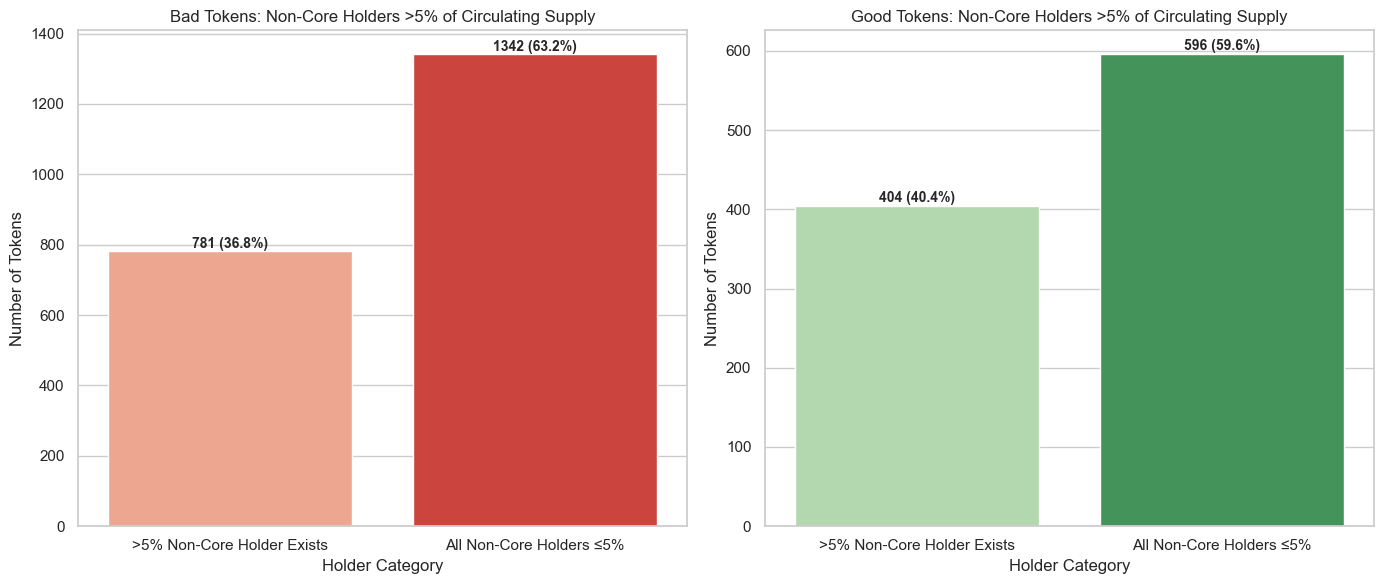

In [22]:
# Load holder summaries
df_holders_bad = pd.read_csv('../csv_outputs/bad_tokens/master_holders.csv')
df_holders_good = pd.read_csv('../csv_outputs/good_tokens/master_holders.csv')

# Function to determine whether any non-core holder exceeds 5%
def analyze_non_core_holders(df_holders):
    # Ensure boolean columns are interpreted correctly
    for col in ['owner_exceeds_5_percent_circulating', 'creator_exceeds_5_percent_circulating', 'owner_is_creator']:
        df_holders[col] = df_holders[col].astype(bool)

    # Fill NaNs in count column (if any)
    df_holders['howmany_holders_exceeding_5_percent_circulating'] = pd.to_numeric(
        df_holders['howmany_holders_exceeding_5_percent_circulating'], errors='coerce').fillna(0)

    # Compute how many core holders (owner, creator) exceed 5%
    core_holder_exceeds = (
        df_holders['owner_exceeds_5_percent_circulating'].astype(int) +
        df_holders['creator_exceeds_5_percent_circulating'].astype(int)
    )

    # If owner is also creator and both exceed, count only once
    both_exceed = df_holders['owner_is_creator'] & \
                  df_holders['owner_exceeds_5_percent_circulating'] & \
                  df_holders['creator_exceeds_5_percent_circulating']
    core_holder_exceeds[both_exceed] = 1  # Adjust overcounting

    # Compute how many non-core holders exceed 5%
    df_holders['non_core_holders_exceed'] = (
        df_holders['howmany_holders_exceeding_5_percent_circulating'] > core_holder_exceeds
    )

    # Count categories
    count_with_large_non_core = df_holders['non_core_holders_exceed'].sum()
    count_all_small_non_core = len(df_holders) - count_with_large_non_core

    return {
        '>5% Non-Core Holder Exists': count_with_large_non_core,
        'All Non-Core Holders ≤5%': count_all_small_non_core,
        'Total': len(df_holders)
    }

# Run analysis
bad_stats = analyze_non_core_holders(df_holders_bad)
good_stats = analyze_non_core_holders(df_holders_good)

# Plot dataframes
plot_df_bad = pd.DataFrame({
    'Holder Category': ['>5% Non-Core Holder Exists', 'All Non-Core Holders ≤5%'],
    'Token Count': [bad_stats['>5% Non-Core Holder Exists'], bad_stats['All Non-Core Holders ≤5%']]
})
plot_df_bad['Percentage'] = (plot_df_bad['Token Count'] / bad_stats['Total']) * 100

plot_df_good = pd.DataFrame({
    'Holder Category': ['>5% Non-Core Holder Exists', 'All Non-Core Holders ≤5%'],
    'Token Count': [good_stats['>5% Non-Core Holder Exists'], good_stats['All Non-Core Holders ≤5%']]
})
plot_df_good['Percentage'] = (plot_df_good['Token Count'] / good_stats['Total']) * 100

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.set(style="whitegrid")

# Bad tokens
ax1 = sns.barplot(data=plot_df_bad, x='Holder Category', y='Token Count', palette='Reds', ax=axes[0])
for i, row in plot_df_bad.iterrows():
    ax1.text(i, row['Token Count'] + 1, f"{row['Token Count']} ({row['Percentage']:.1f}%)",
             ha='center', va='bottom', fontsize=10, fontweight='bold')
ax1.set_title("Bad Tokens: Non-Core Holders >5% of Circulating Supply")
ax1.set_xlabel("Holder Category")
ax1.set_ylabel("Number of Tokens")

# Good tokens
ax2 = sns.barplot(data=plot_df_good, x='Holder Category', y='Token Count', palette='Greens', ax=axes[1])
for i, row in plot_df_good.iterrows():
    ax2.text(i, row['Token Count'] + 1, f"{row['Token Count']} ({row['Percentage']:.1f}%)",
             ha='center', va='bottom', fontsize=10, fontweight='bold')
ax2.set_title("Good Tokens: Non-Core Holders >5% of Circulating Supply")
ax2.set_xlabel("Holder Category")
ax2.set_ylabel("Number of Tokens")

plt.tight_layout()
plt.show()

## Top 10 holder % distribution compared to total and circulating supply

In [23]:
df_holders_good['top10_percentage_of_circulating_supply']
df_holders_good

,token_address,chain,token_name,total_holders,total_supply,total_circulating_supply,howmany_holders_exceeding_5_percent_circulating,total_top_10_balance,top10_percentage_of_total_supply,top10_percentage_of_circulating_supply,top_10_less_than_70_percent_of_total,top_10_less_than_70_percent_of_circulating,owner_exceeds_5_percent_circulating,creator_exceeds_5_percent_circulating,owner_is_creator,non_core_holders_exceed
0,0x00000000051b48047be6dc0ada6de5c3de86a588,eth,Baby Shiba Inu,200,4.200000e+08,3.949445e+08,2,1.830475e-10,43.582742,46.347658,True,True,True,True,True,True
1,0x0000000000c5dc95539589fbd24be07c6c14eca4,eth,Milady Cult Coin,200,1.000000e+11,4.583228e+10,3,6.824863e-08,68.248627,148.909528,True,False,True,True,True,True
2,0x0018d5e01e53878f90feab02f1b2019a21adf8b1,eth,Shadowcats,200,1.000000e+06,0.000000e+00,0,6.748819e-13,67.488190,0.000000,True,True,True,True,True,False
3,0x0026dfbd8dbb6f8d0c88303cc1b1596409fda542,eth,SANSHU!,200,1.000000e+09,1.000000e+09,3,9.316632e-10,93.166319,93.166319,False,False,True,True,False,True
4,0x004f747a91e05d0e2fbe8bf3cd39cdb2bcfab02c,eth,TWEET,200,1.000000e+07,0.000000e+00,0,3.951669e-12,39.516687,0.000000,True,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0xff7d6a96ae471bbcd7713af9cb1feeb16cf56b41,bsc,Bedrock,200,1.000000e+09,2.200000e+08,13,8.700458e-10,87.004579,395.475357,False,False,True,True,True,True
996,0xff8c479134a18918059493243943150776cf8cf2,eth,Renq Finance,200,1.000000e+09,0.000000e+00,0,6.497182e-10,64.971820,0.000000,True,True,False,False,True,False
997,0xff931a7946d2fa11cf9123ef0dc6f6c7c6cb60c4,eth,Dancing Baby,200,1.000000e+08,0.000000e+00,0,6.154981e-02,61.549812,0.000000,True,True,True,True,True,False
998,0xffba7529ac181c2ee1844548e6d7061c9a597df4,bsc,Capsule Coin,200,2.423500e+08,1.829472e+09,0,1.242720e-10,51.277891,6.792778,True,True,True,True,False,False


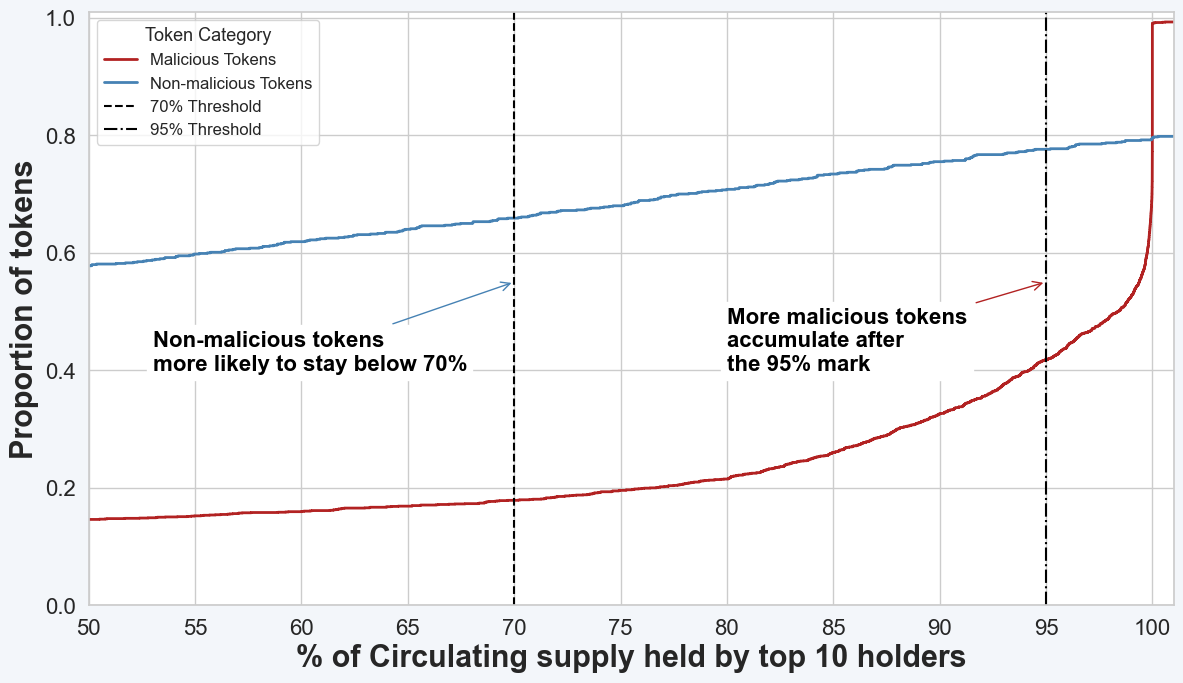

top10_percentage_of_circulating_supply
0.000000e+00    309
6.307391e-08      1
2.022818e-03      1
7.788895e-03      1
1.338863e-02      1
               ... 
1.898656e+03      1
2.164668e+03      1
2.219080e+03      1
2.456187e+03      1
2.759720e+03      1
Name: count, Length: 691, dtype: int64


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Load data
df_holders_bad = pd.read_csv('../csv_outputs/bad_tokens/master_holders.csv')
df_holders_good = pd.read_csv('../csv_outputs/good_tokens/master_holders.csv')

# Convert to numeric
bad_circ_pct = pd.to_numeric(df_holders_bad['top10_percentage_of_circulating_supply'])
good_circ_pct = pd.to_numeric(df_holders_good['top10_percentage_of_circulating_supply'])

# Plot
plt.figure(figsize=(12, 7))
sns.set(style="whitegrid")

# ECDF plots
sns.ecdfplot(bad_circ_pct, label='Malicious Tokens', color='firebrick', linewidth=2)
sns.ecdfplot(good_circ_pct, label='Non-malicious Tokens', color='steelblue', linewidth=2)

# Add threshold lines
plt.axvline(70, color='black', linestyle='--', label='70% Threshold')
plt.axvline(95, color='black', linestyle='-.', label='95% Threshold')

# Axes formatting (no title)
plt.xlabel('% of Circulating supply held by top 10 holders', fontsize=22, fontweight='bold')
plt.ylabel('Proportion of tokens', fontsize=22, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(50, 101)
plt.ylim(0, 1.01)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))

# Annotations
plt.annotate('More malicious tokens\naccumulate after\nthe 95% mark',
             xy=(95, 0.55), xytext=(80, 0.4),
             arrowprops=dict(arrowstyle='->', color='firebrick'),
             fontsize=16, color='black', backgroundcolor='white', fontweight='bold')

plt.annotate('Non-malicious tokens\nmore likely to stay below 70%',
             xy=(70, 0.55), xytext=(53, 0.4),
             arrowprops=dict(arrowstyle='->', color='steelblue'),
             fontsize=16, color='black', backgroundcolor='white', fontweight='bold')

plt.gcf().set_facecolor('#f3f6fa')  
# Legend
plt.legend(title='Token Category', fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()

# Display value counts
print(good_circ_pct.value_counts().sort_index())


## Top 10 token holders possess < 70% of circulating token supply (no locking addresses)

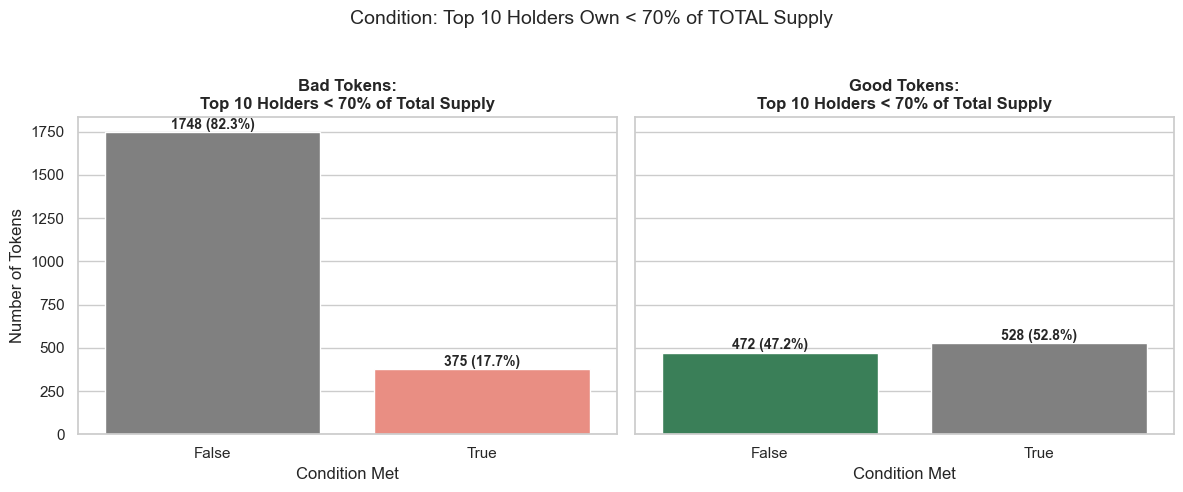

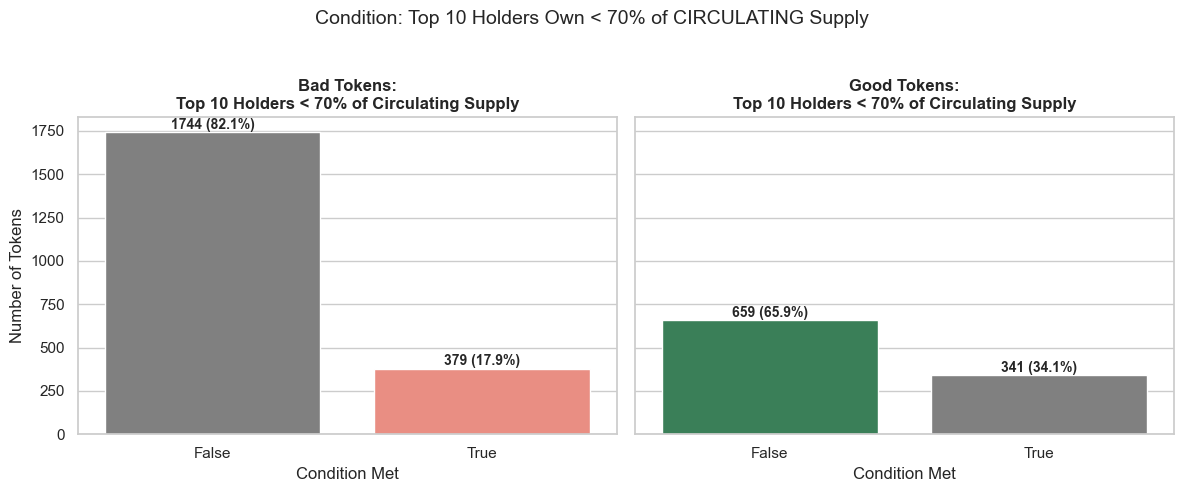

In [25]:
# Load the data
df_holders_bad = pd.read_csv('../csv_outputs/bad_tokens/master_holders.csv')
df_holders_good = pd.read_csv('../csv_outputs/good_tokens/master_holders.csv')

# Convert relevant columns to boolean and then to string for plotting
for df in [df_holders_bad, df_holders_good]:
    df['top_10_less_than_70_percent_of_total'] = df['top_10_less_than_70_percent_of_total'].astype(bool).astype(str)
    df['top_10_less_than_70_percent_of_circulating'] = df['top_10_less_than_70_percent_of_circulating'].astype(bool).astype(str)

# Seaborn style
sns.set(style="whitegrid")

# === PLOT 1: Top 10 < 70% of TOTAL SUPPLY ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, df, label, color in zip(
    axes,
    [df_holders_bad, df_holders_good],
    ['Bad Tokens', 'Good Tokens'],
    ['salmon', 'seagreen']
):
    sns.countplot(
        data=df,
        x='top_10_less_than_70_percent_of_total',
        hue='top_10_less_than_70_percent_of_total',
        palette={'True': color, 'False': 'gray'},
        ax=ax,
        legend=False
    )
    
    total = len(df)
    ax.set_title(f'{label}:\nTop 10 Holders < 70% of Total Supply', fontsize=12, fontweight='bold')
    ax.set_xlabel('Condition Met')
    ax.set_ylabel('Number of Tokens')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['False', 'True'])

    # Annotate bars
    for p in ax.patches:
        count = int(p.get_height())
        pct = (count / total) * 100
        ax.annotate(f'{count} ({pct:.1f}%)',
                    (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Condition: Top 10 Holders Own < 70% of TOTAL Supply', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# === PLOT 2: Top 10 < 70% of CIRCULATING SUPPLY ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, df, label, color in zip(
    axes,
    [df_holders_bad, df_holders_good],
    ['Bad Tokens', 'Good Tokens'],
    ['salmon', 'seagreen']
):
    sns.countplot(
        data=df,
        x='top_10_less_than_70_percent_of_circulating',
        hue='top_10_less_than_70_percent_of_circulating',
        palette={'True': color, 'False': 'gray'},
        ax=ax,
        legend=False
    )
    
    total = len(df)
    ax.set_title(f'{label}:\nTop 10 Holders < 70% of Circulating Supply', fontsize=12, fontweight='bold')
    ax.set_xlabel('Condition Met')
    ax.set_ylabel('Number of Tokens')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['False', 'True'])

    # Annotate bars
    for p in ax.patches:
        count = int(p.get_height())
        pct = (count / total) * 100
        ax.annotate(f'{count} ({pct:.1f}%)',
                    (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Condition: Top 10 Holders Own < 70% of CIRCULATING Supply', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



## All other holders possess < 5% of circulating token supply (Not a single one has > 5%)

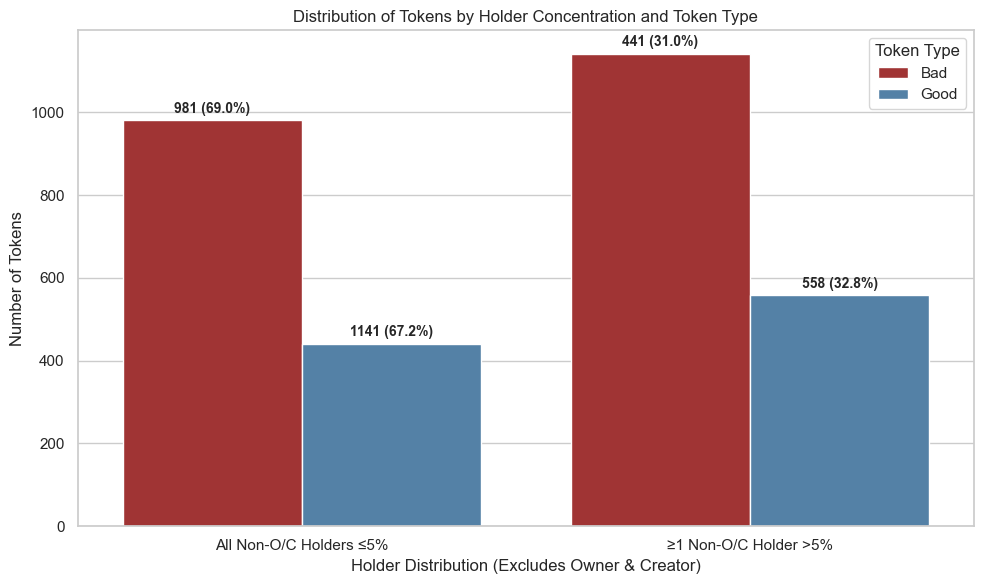

In [26]:
# Normalize and prepare a function for analysis
def analyze_holder_distribution(df_holders_list, df_contracts):
    # Normalize case
    df_holders_list['holder_address'] = df_holders_list['holder_address'].str.lower()
    df_contracts['owner'] = df_contracts['owner'].str.lower()
    df_contracts['creator'] = df_contracts['creator'].str.lower()

    # Merge to get owner and creator info
    df = df_holders_list.merge(
        df_contracts[['token_address', 'owner', 'creator']],
        on='token_address', how='left'
    )

    # Exclude owner and creator addresses
    df_filtered = df[
        (df['holder_address'] != df['owner']) &
        (df['holder_address'] != df['creator'])
    ].copy()

    # Convert percentage to numeric
    df_filtered['percentage_of_circulating_supply'] = pd.to_numeric(
        df_filtered['percentage_of_circulating_supply'], errors='coerce'
    )
    df_filtered = df_filtered.dropna(subset=['percentage_of_circulating_supply'])

    # Get max non-O/C holder share per token
    token_check = df_filtered.groupby('token_address')['percentage_of_circulating_supply'].max().reset_index()

    # Classify tokens
    token_check['Category'] = token_check['percentage_of_circulating_supply'].apply(
        lambda x: 'All Non-O/C Holders ≤5%' if x <= 5 else '≥1 Non-O/C Holder >5%'
    )
    return token_check

# Analyze both datasets
good_result = analyze_holder_distribution(df_holders_list_good, df_contracts_good)
bad_result = analyze_holder_distribution(df_holders_list_bad, df_contracts_bad)

# Add type labels
good_result['Token Type'] = 'Good'
bad_result['Token Type'] = 'Bad'

# Combine results
df_result = pd.concat([good_result, bad_result], ignore_index=True)

# Count per category
plot_df = df_result.groupby(['Token Type', 'Category'])['token_address'].count().reset_index()
plot_df.columns = ['Token Type', 'Holder Concentration', 'Token Count']

# Count per category (swapped grouping)
plot_df = df_result.groupby(['Category', 'Token Type'])['token_address'].count().reset_index()
plot_df.columns = ['Holder Concentration', 'Token Type', 'Token Count']

# Compute percentage labels
plot_df['Percentage'] = plot_df.groupby('Holder Concentration')['Token Count'].transform(lambda x: (x / x.sum()) * 100)

# Plot with new x and hue
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=plot_df,
    x='Holder Concentration',
    y='Token Count',
    hue='Token Type',
    palette={
        'Good': 'steelblue',
        'Bad': 'firebrick'
    }
)

# Annotate bars with counts and percentages
for p, (_, row) in zip(ax.patches, plot_df.iterrows()):
    height = p.get_height()
    if height > 0:
        x = p.get_x() + p.get_width() / 2
        count = row['Token Count']
        pct = row['Percentage']
        ax.text(x, height + max(plot_df['Token Count']) * 0.01, f'{count} ({pct:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Distribution of Tokens by Holder Concentration and Token Type")
plt.xlabel("Holder Distribution (Excludes Owner & Creator)")
plt.ylabel("Number of Tokens")
plt.legend(title="Token Type")
plt.tight_layout()
plt.show()
